Need to simplify the loading and setting up of a new tracklog

We should immediately load the GPS to get the proper timings so 
everything correlates between IGC and datalogged, and then be able to 
plot sets of IGCs at a time.

We should load Q records with the correct datetime, and offset the others 
by Rdatetime0

We need the R record because it has the date in it!
* Plot colour by velocity
* Plot whiskers for orientation and bank angles



Things to do:
* Clarify Hough transform calculations as a means to generate a vx vy for the wind
* Calculate wind direction within short section using Hough
* Subtract wind direction from position (or velocity)

* Plot terrain underlay
* Interactive plot 2 flights at a time (list of fds)


In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from hacktrack import loaders, utils
import pandas, numpy, matplotlib

fname = "data/022.TXT"
#fname = "data/022-short.TXT"
fd = loaders.FlyDat(fname, knowndate="2018-08-05")


Made for Q 19456 last index 19456
Setting new Rdatetime0 2018-08-05 12:07:27.477198961 with std 23.19
Made for V 19423 last index 19423


In [2]:
from hacktrack import clickables

In [3]:
from hacktrack import clickables
clickables.plotinteractivegpstrack(fd)


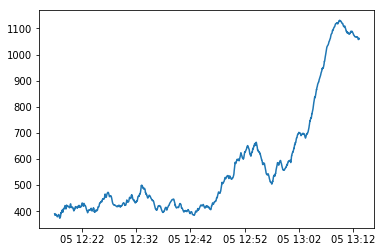

In [3]:
plt.plot(fd.pQ.alt[fd.ft0:])

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
from hacktrack import loaders, utils
import pandas, numpy, matplotlib

fdI = loaders.FlyDat("data/885B0912.IGC", fdother=fd)


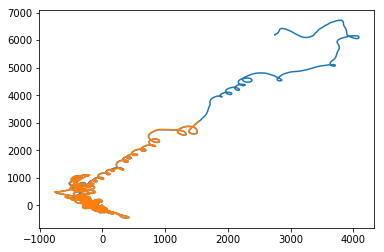

In [3]:
plt.plot(fdI.pIGC.x, fdI.pIGC.y)
plt.plot(fd.pQ.x, fd.pQ.y)

In [2]:
plt.plot(fdI.pIGC.altb)
plt.plot(fd.pQ.alt)


NameError: name 'fdI' is not defined

In [20]:
widgets.fixed

ipywidgets.widgets.interaction.fixed

In [31]:

# handy interactive things
#from ipywidgets import interact, Layout, interactive, fixed, interact_manual
#idgets import interact, interactive, fixed, interact_manual
import pandas, numpy
import ipywidgets as widgets
from IPython.display import display
from matplotlib.collections import LineCollection
from matplotlib import pyplot as plt

def plotvalcolour(pQx, pQy, pval):
    points = numpy.array([pQx, pQy]).T.reshape(-1, 1, 2)
    segments = numpy.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, cmap=plt.get_cmap('cool'), norm=plt.Normalize(min(pval), max(pval)))
    lc.set_array(pval)
    cs = plt.gca().add_collection(lc)
    plt.xlim(min(pQx), max(pQx))  # why is this necessary to set the dimensions?
    plt.ylim(min(pQy), max(pQy))
    plt.colorbar(cs)

def plotwhiskers(pQx, pQy, vel, deg, velfac, col):
    spQx = pQx.iloc[::int(len(pQx)/500+1)]
    spQy = pQy.iloc[::int(len(pQy)/500+1)]
    svel = utils.InterpT(spQx, vel)
    if col == "green":
        svel = -(40-svel)*(velfac/4)
    else:
        svel = svel*velfac
    sdeg = utils.InterpT(spQx, deg)
    srad = numpy.radians(sdeg)
    svx = numpy.sin(srad)*svel
    svy = numpy.cos(srad)*svel
    segments = numpy.array([spQx, spQy, spQx+svx, spQy+svy]).T.reshape(-1,2,2)
    lc = LineCollection(segments, color=col)
    plt.gca().add_collection(lc)
    
outputfigure = None
t0t1Label = None
def plotfigure(t0s, dts, colos, figureheight, velwhisker, headingwhisker, wx, wy, fd):
    if outputfigure:  outputfigure.layout.height = figureheight

    t0 = pandas.Timestamp(t0s*3600*1e9 + fd.timestampmidnight.value)
    t1 = pandas.Timedelta(dts*60*1e9) + t0
    t0t1Label.value = "%s %s-%s" % (t0.isoformat()[:10], t0.isoformat()[11:19], t1.isoformat()[11:19])
    fd.t0, fd.t1 = t0, t1
    plt.figure(figsize=(8,8))
    pQ = fd.pQ[t0:t1]

    plt.gca().xaxis.tick_top()
    
    # timewise plot
    if colos == "TZ":  
        plt.plot(pQ.alt)
        plt.show()
        return
    
    # xy plots
    pQ = fd.pQ[fd.t0:fd.t1]
    if wx == 0 and wy == 0:
        pQx, pQy = pQ.x, pQ.y
    else:
        ts = (pQ.index - fd.t0).astype(int)*1e-9
        pQx, pQy = pQ.x - ts*wx, pQ.y - ts*wy
    
    plt.subplot(111, aspect="equal")
    if colos == "altitude":
        plotvalcolour(pQx, pQy, pQ.alt)
    elif colos == "velocity":
        # warning, velocity not changed by wind vector
        velmag = utils.InterpT(pQ, fd.pV.vel)
        if wx != 0 or wy != 0:
            veldeg = utils.InterpT(pQ, fd.pV.deg)
            velrad = numpy.radians(veldeg)
            velvx = numpy.sin(velrad)*velmag
            velvy = numpy.cos(velrad)*velmag
            velmag = numpy.hypot(velvx - wx, velvy - wy)
            
        plotvalcolour(pQx, pQy, velmag)
        
    elif colos == "YZ":
        plt.plot(pQy, pQ.alt)
        plt.scatter(pQ5.x, pQ5.alt)
    else:
        plt.plot(pQx, pQy)
        plt.scatter(pQx.iloc[-5:], pQy.iloc[-5:])
    
    if velwhisker != 0:
        # warning, velocity not changed by wind vector
        plotwhiskers(pQx, pQy, fd.pV.vel, fd.pV.deg, velwhisker, "pink")
    if headingwhisker != 0:
        fd.LoadC("Z")
        plotwhiskers(pQx, pQy, fd.pZ.pitch, fd.pZ.heading, headingwhisker, "green")
    
    plt.show()

def plotinteractivegpstrack(fd):
    global outputfigure, t0t1Label
    t0hour = (fd.ft0-fd.timestampmidnight).value/1e9/3600
    t1hour = (fd.ft1-fd.timestampmidnight).value/1e9/3600
    dtminutes = (fd.ft1 - fd.ft0).value/1e9/60

    t0t1Label = widgets.Label(value="t0")
    t0t1Label.layout.width = "300px"
    t0slider = widgets.FloatSlider(description="starthour", step=1/3600, min=t0hour, max=t1hour, continuous_update=False)
    dtslider = widgets.FloatSlider(description="minutes", value=3, step=1/60, max=dtminutes, continuous_update=False)
    figureheightSelection = widgets.SelectionSlider(options=['300px', '400px', '500px', '600px', '800px'], value='400px', description='display height', continuous_update=False)

    hcolcb = widgets.Checkbox(description="Colour by height", value=False)
    coloptions = widgets.Dropdown(options=['none', 'altitude', 'velocity', 'YZ', 'TZ'])
    velwhisker = widgets.IntSlider(min=0, max=5, description="velicity whiskers", continuous_update=False)
    headingwhisker = widgets.IntSlider(min=0, max=5, description="heading whiskers", continuous_update=False)

    windxslider = widgets.FloatSlider(description="windx", step=0.01, min=-10, max=10, start=0, continuous_update=False)
    windyslider = widgets.FloatSlider(description="windy", step=0.01, min=-10, max=10, start=0, continuous_update=False)

    uipaneleft = widgets.VBox([t0slider, dtslider, t0t1Label, figureheightSelection])
    uipaneright = widgets.VBox([hcolcb, coloptions, velwhisker, headingwhisker])
    uipanefarright = widgets.VBox([windxslider, windyslider])
    ui = widgets.HBox([uipaneleft, uipaneright, uipanefarright])

    params = {'t0s': t0slider, 'dts': dtslider, 
              "velwhisker":velwhisker, "headingwhisker":headingwhisker, 
              "colos":coloptions, 
              "figureheight":figureheightSelection, 
              "wx":windxslider, "wy":windyslider, 
              'fd':widgets.fixed(fd) }
    outputfigure = widgets.interactive_output(plotfigure, params)
    outputfigure.layout.height = '400px'
    display(ui, outputfigure);

plotinteractivegpstrack(fd)

In [29]:
numpy.hypot

<ufunc 'hypot'>

In [24]:
# Hough transform calculations (to get the velocity vectors, instead of by eye)
# define the grid array of velocities as between -10 and +10m/s
wsx = numpy.linspace(-5, 5, 21)
wsy = numpy.linspace(-5, 5, 21)
td = 2  # seconds between each sample
wxx, wyy = numpy.meshgrid(wsx, wsy)

# with too narrow a band (large houghspread) the single point sample in each cell is not 
# representative of the overall value that should be assigned to the cell
def F(p0x, p0y, p1x, p1y, p2x, p2y, houghspread, wxx, wyy):
    D = numpy.exp(-houghspread*(((p1x - p0x - wxx*td)**2 + (p1y - p0y - wyy*td)**2) - 
                                ((p2x - p1x - wxx*td)**2 + (p2y - p1y - wyy*td)**2))**2)
    return D / sum(sum(D))


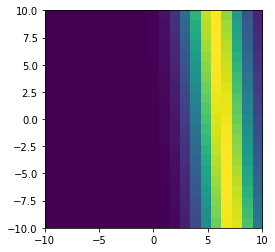

In [5]:
# example showing of the probability field
houghspread = 0.0002
Hextents = [wsx[0], wsx[-1], wsy[0], wsy[-1]]
D = F(0, 0, 10, 0, 26.4, 0.5, houghspread, wxx, wyy)
plt.imshow(D, origin='lower', extent=Hextents)

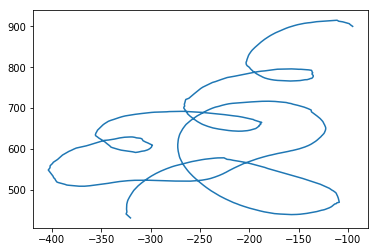

In [16]:
pQ = fd.pQ[fd.t0:fd.t1]
len(pQ)
plt.plot(pQ.x, pQ.y)

Peak value 0.0 -1.0


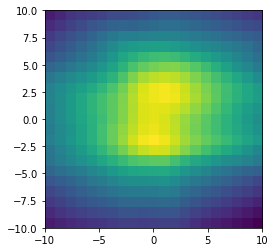

In [26]:
# sum these probability fields for sets of three points in the tracklog
def houghtrack(tlx, tly, houghspread):
    H = numpy.zeros((len(wsx), len(wsy)))
    for i in range(2, len(tlx)):
        H += F(tlx[i-2], tly[i-2], tlx[i-1], tly[i-1], tlx[i], tly[i], 
               houghspread, wxx, wyy)
    return H

tlx, tly = pQ.x, pQ.y
H = houghtrack(tlx, tly, houghspread*100)
plt.imshow(H, origin='lower', extent=Hextents)
iy, ix = numpy.unravel_index(H.argmax(), H.shape)
print("Peak value", wsx[ix], wsy[iy])


In [10]:
# to make the short version
t = open("data/022.TXT").read()
import re
print(len(t))
t1 = re.sub("N.*?\n", "", t)
print(len(t1))
k1 = t1.find("\n\n")
t1[:k1+2]
s1 = k1+10000018
s2 = k1+10360050
t2 = t1[s1:s2]
f = open("data/022-short.TXT", "w")
f.write(t1[:k1+2]+t1[s1:s2])
f.close()

26105569
24487596
